In [1]:
import numpy as np
import tensorflow as tf
import os
from scipy.special import expit# use for the sigmoid function.
import cv2

In [2]:
def scale_boxes(boxes, image_shape):
    height = image_shape[0]
    width = image_shape[1]
    image_dims = np.stack([height, width, height, width])
    imags_dims = np.resize(image_dims,[1,4])
    boxes = np.multiply(boxes ,image_dims)
    return boxes
#get scale is array([height_value,width_value,height_value,width_value])
# use for mutiply to boxes([y1,x1,y2,x2]) to get back the coordinate of bouding box.


In [3]:
anchors = "0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828"
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1,2)
grid_h =19
grid_w =19
num_class =80
def yolo_head(feature_tensor,anchors, num_classes):
    """feature_tensor: output_data of yolov2: shape of array: (number_input_data,19,19,5,85)
    feature_tensor is arranged :(tx,ty,tw,th,box_confidence,80 class probabilities)
    anchor: pair of the value [height_scale,width_scale] of bouding box
    num_classes: 80 """
    num_anchor = len(anchors)
    anchors_tensor = np.reshape(anchors,(1,1,1,num_anchor,2))
    #get the coordinate of grid image. for example: (0,0),(0,1),(0,2),...(0,19);(1,0),(1,1),(1,2),..,(1,19);
                                                #(19,0),(19,1),.....(19,19)
    grid_wh = np.reshape([grid_h,grid_w],(1,1,1,1,2)).astype(np.float32)
    cxcy = np.transpose([np.tile(np.arange(grid_w),grid_h), np.repeat(np.arange(grid_h),grid_h)])
    cxcy = np.reshape(cxcy,(1,19,19,1,2)).astype(np.float32)
    txty = feature_tensor[...,0:2]
    twth = feature_tensor[...,2:4]
    # use some fomulation to get the coordinate of bounding box, box_confidence or probabilities
    box_confidence = expit(feature_tensor[...,4:5])
    box_class_probs = expit(feature_tensor[...,5:])#equal to tf.sigmoid(feature_tensor[...,5:])
    bwbh = np.multiply(np.exp(twth),anchors_tensor)
    bxby = expit(txty)+ cxcy
    box_xy = bxby/grid_wh
    box_wh = bwbh/grid_wh
    return box_confidence,box_xy, box_wh, box_class_probs
def yolo_boxes_to_corners(box_xy, box_wh):
    box_mins = box_xy -(box_wh/2.)
    box_maxes = box_xy +(box_wh/2.)
    return np.concatenate((box_mins[...,1:2],box_mins[...,0:1],box_maxes[...,1:2],box_maxes[...,0:1]),axis=-1)
#return boxes array gets shape (1,19,19,5,2): an array([[[[[y1,x1,y2,x2]]]]])

In [4]:
data_image_dir = os.path.join(os.getcwd()+'/images/horses.jpg')
image = cv2.imread(data_image_dir)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_input = np.array(image,dtype = np.float32)/255
height = image_input.shape[0]
width = image_input.shape[1]
def slicing_image(image_input):
    if len(image_input.shape) ==2:
        image_input = image_input[:,:,np.newaxis]
        image_input = np.concatenate([image_input,image_input,image_input], -1)
    image_input = np.reshape(image_input,(height,width,3))
    image_fixed = np.array((608,608,3))
    concatenate_image = np.zeros((96,width,3))
    image_addn =np.concatenate((image_input,concatenate_image),axis = 0)
    image_fixed = image_addn[0:608,0:608,:]
    image_top_left = np.array((image_fixed.shape),dtype= np.float32)
    # making sure the intensity of the pixel not be lost when I try to change the shape image to (608,608,3)
    image_top_left = cv2.resize(image_fixed[0:304,0:304],(608,608), interpolation = cv2.INTER_LINEAR)
    image_top_right = np.array((image_fixed.shape),dtype= np.float32)
    image_top_right = cv2.resize(image_fixed[0:304,304:608],(608,608), interpolation = cv2.INTER_LINEAR)
    image_down_left = np.array((image_fixed.shape),dtype= np.float32)
    image_down_left = cv2.resize(image_fixed[304:608,0:304],(608,608), interpolation = cv2.INTER_LINEAR)
    image_down_right = np.array((image_fixed.shape),dtype= np.float32)
    image_down_right = cv2.resize(image_fixed[304:608,304:608],(608,608), interpolation = cv2.INTER_LINEAR)
    return image_top_left, image_top_right, image_down_left, image_down_right

In [5]:
def center_image(image_input):
    if len(image_input.shape) ==2:
        image_input = image_input[:,:,np.newaxis]
        image_input = np.concatenate([image_input,image_input,image_input], -1)
    image_input = np.reshape(image_input,(height,width,3))
    image_fixed = np.array((608,608,3))
    concatenate_image = np.zeros((96,width,3))
    image_addn =np.concatenate((image_input,concatenate_image),axis = 0)
    image_fixed = image_addn[0:608,0:608,:]
    image_center = np.array((608,608,3),dtype = np.float32)
    image_center = cv2.resize(image_fixed[152:429,152:429],(608,608), interpolation = cv2.INTER_LINEAR)
    return image_center
#add np.newaxis- axis =0 of the image as the input of architecture CNN.
# do it before feedicting into conv-layer

In [6]:
image_top_left, image_top_right, image_down_left, image_down_right = slicing_image(image_input)

In [7]:
from matplotlib import pyplot as plt

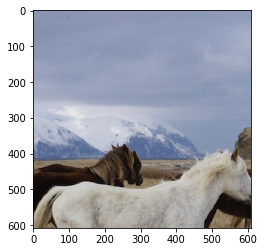

In [8]:
plt.imshow(image_top_left)

(608, 608, 3)

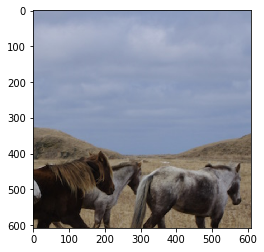

In [9]:
plt.imshow(image_top_right)
image_top_right.shape

(608, 608, 3)

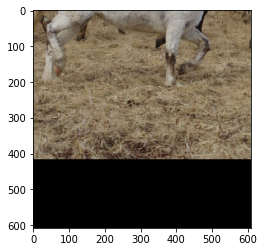

In [10]:
plt.imshow(image_down_left)
image_down_left.shape

(608, 608, 3)

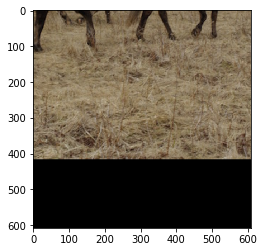

In [11]:
plt.imshow(image_down_right)
image_down_right.shape

In [12]:
image_center = center_image(image_input)
image_center.shape

(608, 608, 3)

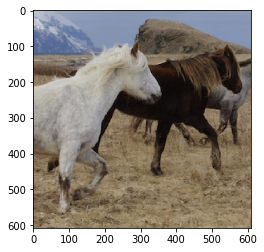

In [13]:
plt.imshow(image_center)

In [14]:
# expand dimension of image_input_data
# and concatenate those images into the batch of data input to architecture CNN
image_center = image_center[np.newaxis,...]
image_top_left = image_top_left[np.newaxis,...] 
image_top_right = image_top_right[np.newaxis,...]
image_down_left = image_down_left[np.newaxis,...]
image_down_right = image_down_right[np.newaxis,...]

In [15]:
#running the model yolov2
tf.reset_default_graph()
path_to_protbuf_file = os.path.join(os.getcwd()+'/yolo_or.pb')
with tf.gfile.GFile(path_to_protbuf_file,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
graph = tf.Graph()
with graph.as_default():
        tf.import_graph_def(graph_def, name ='')
with tf.Session(graph = graph) as sess: 
        layers = [op.name for op in sess.graph.get_operations()]
        for layer in layers:
            print(layer)
        in_tensor = graph.get_tensor_by_name('input:0')
        out_tensor = graph.get_tensor_by_name('output:0')
        image_input = np.concatenate((image_center,image_top_left,image_top_right,image_down_left,image_down_right),axis=0)
        output_data = sess.run(out_tensor, feed_dict={in_tensor: image_input})

input
Pad/paddings
Pad
0-convolutional/filter
0-convolutional
sub/y
sub
truediv/y
truediv
mul/y
mul
BiasAdd/bias
BiasAdd
mul_1/x
mul_1
1-leaky
2-maxpool
Pad_1/paddings
Pad_1
3-convolutional/filter
3-convolutional
sub_1/y
sub_1
truediv_1/y
truediv_1
mul_2/y
mul_2
BiasAdd_1/bias
BiasAdd_1
mul_3/x
mul_3
4-leaky
5-maxpool
Pad_2/paddings
Pad_2
6-convolutional/filter
6-convolutional
sub_2/y
sub_2
truediv_2/y
truediv_2
mul_4/y
mul_4
BiasAdd_2/bias
BiasAdd_2
mul_5/x
mul_5
7-leaky
Pad_3/paddings
Pad_3
8-convolutional/filter
8-convolutional
sub_3/y
sub_3
truediv_3/y
truediv_3
mul_6/y
mul_6
BiasAdd_3/bias
BiasAdd_3
mul_7/x
mul_7
9-leaky
Pad_4/paddings
Pad_4
10-convolutional/filter
10-convolutional
sub_4/y
sub_4
truediv_4/y
truediv_4
mul_8/y
mul_8
BiasAdd_4/bias
BiasAdd_4
mul_9/x
mul_9
11-leaky
12-maxpool
Pad_5/paddings
Pad_5
13-convolutional/filter
13-convolutional
sub_5/y
sub_5
truediv_5/y
truediv_5
mul_10/y
mul_10
BiasAdd_5/bias
BiasAdd_5
mul_11/x
mul_11
14-leaky
Pad_6/paddings
Pad_6
15-convolu

In [16]:
output_data

array([[[[-5.23749113e-01, -3.32137674e-01, -4.82701331e-01, ...,
           8.91634107e-01, -1.02249706e+00,  5.46541691e-01],
         [-3.95278454e-01, -1.42768526e+00,  4.94537652e-01, ...,
           9.62739587e-02, -1.08705151e+00,  7.77426481e-01],
         [-4.05130804e-01, -1.54258668e+00,  6.07392430e-01, ...,
           7.84859598e-01, -1.46470642e+00,  7.01839983e-01],
         ...,
         [ 6.51949704e-01, -2.18215585e+00,  8.59851241e-01, ...,
           2.18817919e-01, -1.89031470e+00, -1.18388069e+00],
         [-6.77312434e-01, -3.71801615e+00,  7.55341053e-01, ...,
          -3.39429900e-02, -1.48605669e+00,  1.00166634e-01],
         [ 1.63104427e+00, -5.89774489e-01, -3.47737789e-01, ...,
          -1.07234216e+00, -7.55586624e-01,  6.91969156e-01]],

        [[-1.69838786e+00, -8.08664858e-02, -1.12558007e+00, ...,
           7.19221592e-01, -8.29294920e-01,  1.13124633e+00],
         [-5.21072149e-01,  4.85340923e-01, -3.75722289e-01, ...,
           2.25502536e

In [17]:
output_data = np.reshape(output_data,(5,19,19,5,85))

In [18]:
output_image_center = output_data[0,:,:,:,:]

In [19]:
box_confidence,box_xy, box_wh, box_class_probs =yolo_head(output_image_center,anchors,num_class)

In [20]:
box_confidence.shape

(19, 19, 5, 1)

In [21]:
box_xy.shape

(1, 19, 19, 5, 2)

In [22]:
box_wh

array([[[[[0.01860209, 0.01993852],
          [0.06897444, 0.09138204],
          [0.08558043, 0.36712686],
          [0.38964164, 0.09710203],
          [0.53756647, 0.57422584]],

         [[0.0494278 , 0.00534063],
          [0.14581702, 0.05173869],
          [0.15274058, 0.26470592],
          [0.38611284, 0.11135982],
          [0.47512686, 0.4628275 ]],

         [[0.05533291, 0.00313185],
          [0.22779057, 0.03617698],
          [0.22572874, 0.25321583],
          [0.3575458 , 0.11417339],
          [0.41658808, 0.46328504]],

         ...,

         [[0.07122377, 0.00459016],
          [0.19641055, 0.02958325],
          [0.15136549, 0.15473096],
          [0.45068829, 0.08428831],
          [0.59353722, 0.40206139]],

         [[0.06415593, 0.00990589],
          [0.1152899 , 0.03548052],
          [0.29918842, 0.33768029],
          [0.20961471, 0.17334397],
          [0.18355735, 0.43998014]],

         [[0.02129   , 0.02422494],
          [0.07988084, 0.1167672 ],
   

In [23]:
box_class_probs = box_class_probs[np.newaxis,...]

In [24]:
box_class_probs.shape

(1, 19, 19, 5, 80)

In [25]:
boxes = yolo_boxes_to_corners(box_xy,box_wh)
boxes.shape

(1, 19, 19, 5, 4)

In [26]:
boxes

array([[[[[ 1.20160322e-02,  1.02766391e-02,  3.19545564e-02,
            2.88787324e-02],
          [-8.19743573e-03, -2.97562599e-03,  8.31846088e-02,
            6.59988132e-02],
          [-1.47870582e-01, -1.25492822e-02,  2.19256279e-01,
            7.30311435e-02],
          [-1.36395528e-02, -1.68131559e-01,  8.34624751e-02,
            2.21510077e-01],
          [-2.53714141e-01, -2.41944376e-01,  3.20511695e-01,
            2.95622092e-01]],

         [[ 7.51176920e-03,  4.90991115e-02,  1.28523998e-02,
            9.85269160e-02],
          [ 6.23849660e-03,  4.84550090e-03,  5.79771859e-02,
            1.50662526e-01],
          [-9.59439124e-02, -4.28201701e-03,  1.68762005e-01,
            1.48458560e-01],
          [-2.25090781e-02, -1.09620030e-01,  8.88507465e-02,
            2.76492815e-01],
          [-1.96022101e-01, -1.55092187e-01,  2.66805403e-01,
            3.20034675e-01]],

         [[ 7.70563307e-03,  9.86535487e-02,  1.08374781e-02,
            1.53986460e-

In [27]:
box_class_probs.shape
box_confidence = box_confidence[np.newaxis,...]
box_confidence.shape

(1, 19, 19, 5, 1)

In [28]:
def yolo_filter_boxes_array_low(box_confidence,boxes, box_class_probs, threshold = 0.4):
    box_scores = np.multiply(box_confidence,box_class_probs)
    box_classes = np.argmax(box_scores,axis =-1)
    box_class_scores = np.max(box_scores,axis =-1)
    scores_coordinate = np.argwhere(box_class_scores>threshold)
    scores = box_class_scores[tuple(scores_coordinate.T)]
    classes = box_classes[tuple(scores_coordinate.T)]
    boxes_final = boxes[tuple(scores_coordinate.T)]
    boxes_final = np.reshape(boxes_final,(len(scores_coordinate),4))
    return scores, boxes_final, classes
# calculate the scores,boxes_final,classes array which be defined before.

In [29]:
scores, boxes_final, classes = yolo_filter_boxes_array_low(box_confidence, boxes,box_class_probs,threshold =0.4)

In [30]:
scores

array([0.5819994 , 0.5280409 , 0.79367626, 0.8312984 , 0.8717787 ,
       0.49291018, 0.83069855, 0.45928538, 0.81798697, 0.8147389 ,
       0.5927289 , 0.8279678 ], dtype=float32)

In [31]:
boxes_final

array([[ 1.27361579e-01, -2.07835052e-02,  7.94721500e-01,
         5.80522201e-01],
       [ 1.36866987e-01,  1.29624994e-01,  7.74192631e-01,
         8.71332972e-01],
       [ 1.28721489e-01,  1.87035273e-01,  7.84416245e-01,
         9.14863635e-01],
       [ 1.37356771e-01,  2.76940524e-01,  7.80577468e-01,
         9.43936647e-01],
       [ 1.34547497e-01,  3.21486713e-01,  7.83851003e-01,
         9.74033235e-01],
       [ 1.38401125e-01,  3.04777674e-03,  8.71267344e-01,
         4.99170827e-01],
       [ 1.31034681e-01, -7.92440633e-03,  8.79513434e-01,
         5.77330737e-01],
       [ 1.98574059e-01,  1.88899593e-01,  7.98020847e-01,
         9.24656196e-01],
       [ 1.92352659e-01,  2.67138096e-01,  7.99748832e-01,
         9.62486057e-01],
       [ 1.84517771e-01,  3.23330306e-01,  7.98811227e-01,
         9.76734258e-01],
       [ 1.55847305e-01, -9.64526403e-03,  9.40795189e-01,
         5.07857572e-01],
       [ 1.67279367e-01,  1.75764504e-04,  9.28638812e-01,
      

In [32]:
classes

array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18])

In [33]:
image_shape = np.array([608,608])
boxes_final = scale_boxes(boxes_final,image_shape)

In [34]:
boxes_final

array([[ 7.74358403e+01, -1.26363712e+01,  4.83190672e+02,
         3.52957498e+02],
       [ 8.32151283e+01,  7.88119964e+01,  4.70709119e+02,
         5.29770447e+02],
       [ 7.82626655e+01,  1.13717446e+02,  4.76925077e+02,
         5.56237090e+02],
       [ 8.35129169e+01,  1.68379838e+02,  4.74591100e+02,
         5.73913481e+02],
       [ 8.18048781e+01,  1.95463922e+02,  4.76581410e+02,
         5.92212207e+02],
       [ 8.41478843e+01,  1.85304826e+00,  5.29730545e+02,
         3.03495863e+02],
       [ 7.96690860e+01, -4.81803905e+00,  5.34744168e+02,
         3.51017088e+02],
       [ 1.20733028e+02,  1.14850953e+02,  4.85196675e+02,
         5.62190967e+02],
       [ 1.16950416e+02,  1.62419962e+02,  4.86247290e+02,
         5.85191522e+02],
       [ 1.12186805e+02,  1.96584826e+02,  4.85677226e+02,
         5.93854429e+02],
       [ 9.47551617e+01, -5.86432053e+00,  5.72003475e+02,
         3.08777404e+02],
       [ 1.01705855e+02,  1.06864818e-01,  5.64612398e+02,
      

In [35]:
def draw_box_n(image,boxes_final_1,classes,scores,labelstext):
    if len(boxes_final_1)==0:
        return image
    else:
        for i in range(len(boxes_final_1)):
            x1 = boxes_final_1[i,1:2]
            y1 = boxes_final_1[i,0:1]
            x2 = boxes_final_1[i,3:4]
            y2 = boxes_final_1[i,2:3]
            cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),2)
            for j,x in enumerate(labelstext):
                if j == classes[i]:
                    text ="{}:{:.4f}".format(x,scores[i])
                    cv2.putText(image,text,(x1,y1-5.0),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2)
    return image

In [36]:
labelstext =["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [37]:
image_center_copy_new_low = np.array((608,608,3))
image_center_copy_new_low = image_center[0,...]

In [38]:
image_center_copy_new_low = draw_box_n(image_center_copy_new_low,boxes_final,classes,scores,labelstext)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


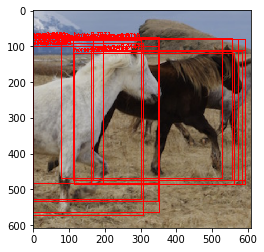

In [39]:
plt.imshow(image_center_copy_new_low)

In [40]:
output_data_tr = output_data[2,:,:,:,:]

In [41]:
output_data_tr

array([[[[ 2.76405253e-02,  3.65536809e-01, -6.72197819e-01, ...,
           1.58413517e+00, -1.91972601e+00, -1.49284256e+00],
         [ 1.05006731e+00,  2.33271718e+00,  3.94809805e-02, ...,
           2.02493429e+00, -1.92488253e+00, -3.08774769e-01],
         [ 1.20997882e+00,  1.81246150e+00, -6.38814807e-01, ...,
          -8.59657049e-01, -2.00619364e+00, -1.08349532e-01],
         [ 3.22736889e-01,  1.33727062e+00, -8.48303735e-03, ...,
          -1.49094081e+00, -1.15269494e+00,  1.37386769e-02],
         [ 1.97390020e-02,  8.04528236e-01,  1.20145440e-01, ...,
          -7.40200043e-01, -6.51515841e-01,  3.77013832e-01]],

        [[-6.67819381e-01, -1.18891716e+00, -2.16054052e-01, ...,
          -2.15975714e+00, -2.76508641e+00, -8.75118375e-01],
         [-1.10797298e+00,  3.34046960e-01,  4.24772441e-01, ...,
          -1.15561056e+00, -2.22935748e+00,  5.94334722e-01],
         [-1.66896105e+00,  1.11421716e+00, -1.33767173e-01, ...,
          -1.65573466e+00, -1.987010

In [42]:
def predict_box(output_image,anchors,num_class):
    box_confidence_lc,box_xy_lc, box_wh_lc, box_class_probs_lc =yolo_head(output_image,anchors,num_class)
    box_class_probs_lc = box_class_probs_lc[np.newaxis,...]
    box_confidence_lc = box_confidence_lc[np.newaxis,...]
    boxes_lc = yolo_boxes_to_corners(box_xy_lc,box_wh_lc)
    scores_lc, boxes_final_lc, classes_lc = yolo_filter_boxes_array_low(box_confidence_lc, boxes_lc,box_class_probs_lc,threshold =0.4)
    image_shape = np.array([608,608])
    boxes_final_lc = scale_boxes(boxes_final_lc,image_shape)
    return boxes_final_lc, scores_lc, classes_lc

In [43]:
boxes_final_tr, scores_tr, classes_tr = predict_box(output_data_tr,anchors,num_class)

In [44]:
image_tr_copy_new = np.array((608,608,3))
image_tr_copy_new = image_top_right[0,...]

In [45]:
image_tr_copy_new = draw_box_n(image_tr_copy_new,boxes_final_tr,classes_tr,scores_tr,labelstext)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


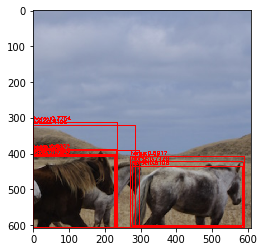

In [46]:
plt.imshow(image_tr_copy_new)

In [47]:
output_data_tl = output_data[1,:,:,:,:]

In [48]:
boxes_final_tl, scores_tl, classes_tl = predict_box(output_data_tl,anchors,num_class)

In [49]:
image_tl_copy_new = np.array((608,608,3))
image_tl_copy_new = image_top_left[0,...]

In [50]:
image_tl_copy_new = draw_box_n(image_tl_copy_new,boxes_final_tl,classes_tl,scores_tl,labelstext)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


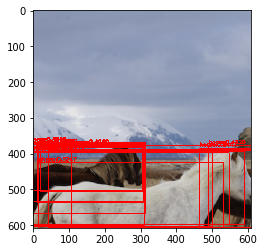

In [51]:
plt.imshow(image_tl_copy_new)

In [52]:
output_data_dl = output_data[3,:,:,:,:]
boxes_final_dl, scores_dl, classes_dl = predict_box(output_data_dl,anchors,num_class)
image_dl_copy_new = np.array((608,608,3))
image_dl_copy_new = image_down_left[0,...]
image_dl_copy_new = draw_box_n(image_dl_copy_new,boxes_final_dl,classes_dl,scores_dl,labelstext)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


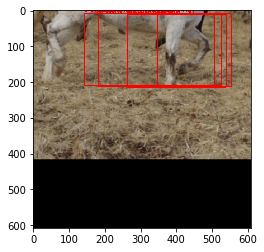

In [53]:
plt.imshow(image_dl_copy_new)

In [54]:
output_data_dr = output_data[4,:,:,:,:]
boxes_final_dr, scores_dr, classes_dr = predict_box(output_data_dr,anchors,num_class)
image_dr_copy_new = np.array((608,608,3))
image_dr_copy_new = image_down_right[0,...]
image_dr_copy_new = draw_box_n(image_dr_copy_new,boxes_final_dr,classes_dr,scores_dr,labelstext)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


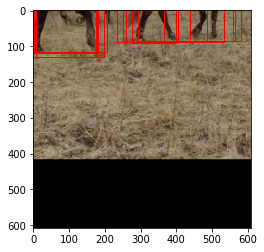

In [55]:
plt.imshow(image_dr_copy_new)

In [56]:
boxes_copy_tl = np.array((boxes_final_tl.shape))
boxes_copy_tl = boxes_final_tl[:,:]

In [57]:
scale_box =np.array([0.25,0.25,0.25,0.25],dtype = np.float32)
boxes_copy_tf_scale = np.multiply(boxes_copy_tl,scale_box)

In [58]:
def reset_image(data_image_dir):
    image = cv2.imread(data_image_dir)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = np.array(image,dtype = np.float32)/255
    height = image.shape[0]
    width = image.shape[1]
    image = np.reshape(image,(height,width,3))
    image_copy = np.array((608,608,3))
    concatenate_image = np.zeros((96,width,3))
    image_addn =np.concatenate((image,concatenate_image),axis = 0)
    image_copy = image_addn[0:608,0:608,:]
    return image_copy

In [59]:
image_copy = reset_image(data_image_dir)

In [60]:
# change the coordinate of each image to the coordinate of the whole image
scale_bb_final = np.array([[0.5,0.5,0.5,0.5]])
offset_tr = np.array([[0,304,0,304]])
offset_dl = np.array([[304,0,304,0]])
offset_dr = np.array([[304,304,304,304]])


In [61]:
bb_tl = boxes_final_tl
bb_tl = boxes_final_tl*scale_bb_final
bb_tr = boxes_final_tr*scale_bb_final
bb_dl = boxes_final_dl*scale_bb_final
bb_dr = boxes_final_dr*scale_bb_final

In [62]:
#bb_tl = bb_tl + offset_tl
bb_tr = bb_tr + offset_tr
bb_dl = bb_dl + offset_dl
bb_dr = bb_dr + offset_dr

In [63]:
def draw_box_bb(image,boxes):
    if len(boxes)==0:
        return image
    else:
        for i in range(len(boxes)):
            x1 = boxes[i,1:2]
            y1 = boxes[i,0:1]
            x2 = boxes[i,3:4]
            y2 = boxes[i,2:3]
            cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),2)
    return image

In [64]:
bb_final_1= np.concatenate((bb_tl,bb_tr,bb_dl,bb_dr),axis=0)
image_copy = draw_box_bb(image_copy,bb_final_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


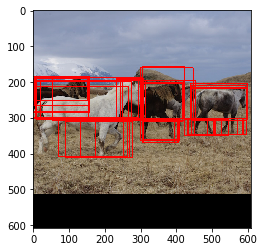

In [65]:
plt.imshow(image_copy)

In [66]:
# move the adjacent box
# pick up the box has larger coordinate_x2
def filter_boxes_quarter_x_axis(boxes,result_quarter):
    x1 = boxes[:,1:2]
    y1 = boxes[:,0:1]
    y2 = boxes[:,2:3]
    x2 = boxes[:,3:4]
    index = np.argsort(x2,axis=0)
    S_area = (x2-x1)*(y2-y1)
    suppression =[]
    pick = []
    for i in range(1,len(boxes)-1):
        for j in range(i+1,len(boxes)):
            if((x2[index[j]]-x2[index[i]]) <= 10.0):
                # calculate Interest of Union value
                x_min = max(x1[index[j]],x1[index[i]])
                y_min = max(y1[index[j]],y1[index[i]])
                x_max = min(x2[index[j]],x2[index[i]])
                y_max = min(y2[index[j]],y2[index[i]])
                #calculate the area of overlap
                intersection_area = np.multiply((x_max - x_min),(y_max- y_min))
                S = float(S_area[index[i]]+S_area[index[j]]-intersection_area)
                iou = np.divide(intersection_area, S)
                if iou >= 0.50:
                    pick.append(index[j])
                    suppression.append(index[i])
    # delete all indexes from the index list that are in the
    # suppression list
    boxes = np.delete(boxes,suppression,axis =0)
    result_quarter = np.delete(result_quarter,suppression,axis=0)
    return boxes,result_quarter
        

In [67]:
# we filter all bounding boxes again after filter it with x axis
# do it one more time with y aixs
def filter_boxes_quarter_y_axis(boxes,result_quarter):
    x1 = boxes[:,1:2]
    y1 = boxes[:,0:1]
    y2 = boxes[:,2:3]
    x2 = boxes[:,3:4]
    index = np.argsort(y2,axis=0)
    S_area = (x2-x1)*(y2-y1)
    suppression =[]
    pick = []
    for i in range(1,len(boxes)-1):
        for j in range(i+1,len(boxes)):
            if((y2[index[j]]-y2[index[i]]) <= 20.0):
                x_min = max(x1[index[j]],x1[index[i]])
                y_min = max(y1[index[j]],y1[index[i]])
                x_max = min(x2[index[j]],x2[index[i]])
                y_max = min(y2[index[j]],y2[index[i]])
                intersection_area = np.multiply((x_max - x_min),(y_max- y_min))
                S = float(S_area[index[i]]+S_area[index[j]]-intersection_area)
                iou = np.divide(intersection_area, S)
                if iou >= 0.70:
                    pick.append(index[j])
                    suppression.append(index[i])
    boxes = np.delete(boxes,suppression,axis =0)
    result_quarter = np.delete(result_quarter,suppression,axis=0)
    return boxes,result_quarter
        

In [68]:
image_copy = reset_image(data_image_dir)
image_top_left_cp= np.array((608,608,3))
image_top_left_cp = cv2.resize(image_copy[0:304,0:304],(608,608), interpolation = cv2.INTER_LINEAR)

In [69]:
# concatenate to the result array:(boxes_y1,boxes_x1,boxes_y2,boxes_x2,scores,classes)
scores = scores[np.newaxis,:]
classes = classes[np.newaxis,:]
scores = np.reshape(scores,(scores.shape[1],1))
classes = np.reshape(classes,(classes.shape[1],1))

In [70]:
result_center = np.concatenate((boxes_final,scores,classes),axis=1)

In [71]:
scores_tr = scores_tr[np.newaxis,:]
classes_tr= classes_tr[np.newaxis,:]
scores_tr = np.reshape(scores_tr,(scores_tr.shape[1],1))
classes_tr = np.reshape(classes_tr,(classes_tr.shape[1],1))
result_quarter_tr = np.concatenate((boxes_final_tr,scores_tr,classes_tr),axis=1)
scores_tl = scores_tl[np.newaxis,:]
classes_tl=classes_tl[np.newaxis,:]
scores_tl = np.reshape(scores_tl,(scores_tl.shape[1],1))
classes_tl = np.reshape(classes_tl,(classes_tl.shape[1],1))
result_quarter_tl = np.concatenate((boxes_final_tl,scores_tl,classes_tl),axis=1)
scores_dl = scores_dl[np.newaxis,:]
classes_dl=classes_dl[np.newaxis,:]
scores_dl = np.reshape(scores_dl,(scores_dl.shape[1],1))
classes_dl = np.reshape(classes_dl,(classes_dl.shape[1],1))
result_quarter_dl = np.concatenate((boxes_final_dl,scores_dl,classes_dl),axis=1)
scores_dr = scores_dr[np.newaxis,:]
classes_dr=classes_dr[np.newaxis,:]
scores_dr = np.reshape(scores_dr,(scores_dr.shape[1],1))
classes_dr = np.reshape(classes_dr,(classes_dr.shape[1],1))
result_quarter_dr = np.concatenate((boxes_final_dr,scores_dr,classes_dr),axis=1)

In [72]:
image_copy = reset_image(data_image_dir)
image_dr_cp= np.array((608,608,3))
image_dr_cp = cv2.resize(image_copy[304:608,304:608],(608,608), interpolation = cv2.INTER_LINEAR)

In [73]:
boxes_filter_dr,result_quarter_dr_filter = filter_boxes_quarter_x_axis(boxes_final_dr,result_quarter_dr)
boxes_filter_dr,result_quarter_dr_filter= filter_boxes_quarter_y_axis(boxes_filter_dr,result_quarter_dr_filter)
image_dr_cp = draw_box_bb(image_dr_cp,boxes_filter_dr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


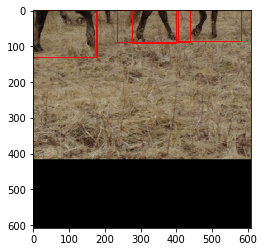

In [74]:
plt.imshow(image_dr_cp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


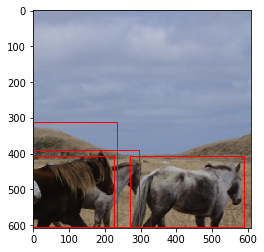

In [75]:
image_copy = reset_image(data_image_dir)
image_top_right_cp= np.array((608,608,3))
image_top_right_cp = cv2.resize(image_copy[0:304,304:608],(608,608), interpolation = cv2.INTER_LINEAR)
boxes_filter_tr,result_quarter_tr_filter = filter_boxes_quarter_x_axis(boxes_final_tr,result_quarter_tr)
boxes_filter_tr,result_quarter_tr_filter = filter_boxes_quarter_y_axis(boxes_filter_tr,result_quarter_tr_filter)
image_top_right_cp = draw_box_bb(image_top_right_cp,boxes_filter_tr)
plt.imshow(image_top_right_cp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


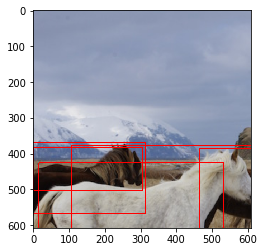

In [76]:
image_copy = reset_image(data_image_dir)
image_top_left_cp= np.array((608,608,3))
image_top_left_cp = cv2.resize(image_copy[0:304,0:304],(608,608), interpolation = cv2.INTER_LINEAR)
boxes_filter_tl,result_quarter_tl_filter = filter_boxes_quarter_x_axis(boxes_final_tl,result_quarter_tl)
boxes_filter_tl,result_quarter_tl_filter = filter_boxes_quarter_y_axis(boxes_filter_tl,result_quarter_tl_filter)
image_top_left_cp = draw_box_bb(image_top_left_cp,boxes_filter_tl)
plt.imshow(image_top_left_cp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


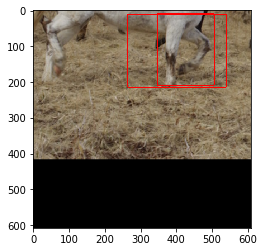

In [77]:
image_copy = reset_image(data_image_dir)
image_down_left_cp= np.array((608,608,3))
image_down_left_cp = cv2.resize(image_copy[304:608,0:304],(608,608), interpolation = cv2.INTER_LINEAR)
boxes_filter_dl,result_quarter_dl_filter = filter_boxes_quarter_x_axis(boxes_final_dl,result_quarter_dl)
boxes_filter_dl,result_quarter_dl_filter = filter_boxes_quarter_y_axis(boxes_filter_dl,result_quarter_dl_filter)
image_down_left_cp = draw_box_bb(image_down_left_cp,boxes_filter_dl)
plt.imshow(image_down_left_cp)

In [78]:
# change the coordinate of each image to the coordinate of the whole image
bb_filter_tl = boxes_filter_tl*scale_bb_final
bb_filter_tr = boxes_filter_tr*scale_bb_final
bb_filter_dl = boxes_filter_dl*scale_bb_final
bb_filter_dr = boxes_filter_dr*scale_bb_final
bb_filter_tr = bb_filter_tr + offset_tr
bb_filter_dl = bb_filter_dl + offset_dl
bb_filter_dr = bb_filter_dr + offset_dr

In [79]:
result_quarter_tl_filter[:,0:4] = result_quarter_tl_filter[:,0:4]*scale_bb_final
result_quarter_tr_filter[:,0:4] = result_quarter_tr_filter[:,0:4]*scale_bb_final
result_quarter_dl_filter[:,0:4] = result_quarter_dl_filter[:,0:4]*scale_bb_final
result_quarter_dr_filter[:,0:4] = result_quarter_dr_filter[:,0:4]*scale_bb_final
result_quarter_tr_filter[:,0:4]= result_quarter_tr_filter[:,0:4]+ offset_tr
result_quarter_dl_filter[:,0:4] = result_quarter_dl_filter[:,0:4]+ offset_dl
result_quarter_dr_filter[:,0:4] = result_quarter_dr_filter[:,0:4]+ offset_dr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


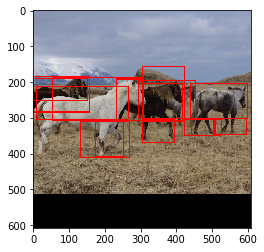

In [80]:
image_copy = reset_image(data_image_dir)
bb_final_filter= np.concatenate((bb_filter_tl,bb_filter_tr,bb_filter_dl,bb_filter_dr),axis=0)
image_copy = draw_box_bb(image_copy,bb_final_filter)
result_final_filter_con = np.concatenate((result_quarter_tl_filter,result_quarter_tr_filter,result_quarter_dl_filter,result_quarter_dr_filter),axis=0)
plt.imshow(image_copy)
image_copy = reset_image(data_image_dir)
image_copy = draw_box_bb(image_copy,result_final_filter_con[:,0:4])
plt.imshow(image_copy)

In [223]:
def merger_bb_x_axis_final_1(boxes,result_quarter):
    x1 = boxes[:,1:2]
    y1 = boxes[:,0:1]
    y2 = boxes[:,2:3]
    x2 = boxes[:,3:4]
    index = np.argsort(x1,axis=0)
    suppression =[]
    pick = []
    count = 0 
    count_local_m = 0
    for i in range(1,len(boxes)-1):
        for j in range(i+1,len(boxes)):
            if np.absolute(x1[index[j]] - x2[index[i]]) <= 20.0 or np.absolute(x2[index[j]]- x1[index[i]]) <= 20.0:
                overlap = np.minimum(y2[index[j]],y2[index[i]]) - np.maximum(y1[index[j]],y1[index[i]])
                L_gather = np.maximum(y2[index[j]],y2[index[i]]) - np.minimum(y1[index[j]],y1[index[i]])
                L = float(overlap/L_gather)
                if L >= 0.7 and (result_quarter[index[j],4:5] <= 0.5 and result_quarter[index[i],4:5] <= 0.5):
                    count += 1
                    suppression.append(index[i])
                    suppression.append(index[j])
                    #get new bbox
                    x1_new =  np.minimum(x1[index[j]],x1[index[i]])
                    y1_new =  np.minimum(y1[index[j]],y1[index[i]])
                    x2_new =  np.maximum(x2[index[j]],x2[index[i]])
                    y2_new = np.maximum(y2[index[j]],y2[index[i]])
                    scores = np.maximum(result_quarter[index[j],4:5],result_quarter[index[i],4:5])
                    classes = result_quarter[index[j],5:6]
                    boxes_new = np.concatenate((y1_new,x1_new,y2_new,x2_new),axis =1)
                    result_new = np.concatenate((y1_new,x1_new,y2_new,x2_new,scores,classes),axis =1)
                    if count_local_m ==0:
                        boxes_final = np.concatenate([boxes_new],axis =0)
                        result_final = np.concatenate([result_new],axis=0)
                        count_local_m +=1
                    else :
                        boxes_final = np.concatenate((boxes_final,boxes_new),axis =0)
                        result_final = np.concatenate((result_final,result_new),axis =0)
                        count_local_m +=1
    #delete indices bouding box of suppression list
    boxes = np.delete(boxes,suppression,axis =0)
    result_quarter= np.delete(result_quarter,suppression,axis =0)
    if count ==0:
        return boxes,result_quarter
    else:
        # merger some new bouding box created
        boxes_final = np.concatenate((boxes_final,boxes),axis=0)
        result_final = np.concatenate((result_final,result_quarter),axis=0)
        return boxes_final,result_final
    

In [244]:
def merger_bb_y_axis_final_1(boxes,result_quarter):
    x1 = boxes[:,1:2]
    y1 = boxes[:,0:1]
    y2 = boxes[:,2:3]
    x2 = boxes[:,3:4]
    index = np.argsort(y2,axis=0)
    suppression =[]
    pick = []
    count=0
    count_local_m = 0
    for i in range(1,len(boxes)-1):
        for j in range(i+1,len(boxes)):
            if np.absolute(y2[index[i]]-y1[index[j]]) <= 20.0 or np.absolute(y1[index[i]]-y2[index[j]]) or  np.absolute(y1[index[j]]- y1[index[i]]) <= 20.0 :
                overlap = np.minimum(x2[index[j]],x2[index[i]]) - np.maximum(x1[index[j]],x1[index[i]])
                L_gather = np.maximum(x2[index[j]],x2[index[i]]) - np.minimum(x1[index[j]],x1[index[i]])
                L = float(overlap/L_gather)
                if L >= 0.3 and (result_quarter[index[j],4:5] <= 0.6 or result_quarter[index[i],4:5] <= 0.6) :
                    count+=1
                    suppression.append(index[i])
                    suppression.append(index[j])
                    #get new bbox
                    x1_new =  np.minimum(x1[index[j]],x1[index[i]])
                    y1_new =  np.minimum(y1[index[j]],y1[index[i]])
                    x2_new =  np.maximum(x2[index[j]],x2[index[i]])
                    y2_new = np.maximum(y2[index[j]],y2[index[i]])
                    scores = np.maximum(result_quarter[index[j],4:5],result_quarter[index[i],4:5])
                    classes = result_quarter[index[j],5:6]
                    boxes_new = np.concatenate((y1_new,x1_new,y2_new,x2_new),axis =1)
                    result_new = np.concatenate((y1_new,x1_new,y2_new,x2_new,scores,classes),axis =1)
                    if count_local_m == 0:
                        boxes_final = np.concatenate([boxes_new],axis =0)
                        result_final = np.concatenate([result_new],axis=0)
                    else :
                        boxes_final = np.concatenate((boxes_final,boxes_new),axis =0)
                        result_final = np.concatenate((result_final,result_new),axis =0)
                    count_local_m +=1
    boxes = np.delete(boxes,suppression,axis =0)
    result_quarter= np.delete(result_quarter,suppression,axis =0)
    if count ==0:
        return boxes,result_quarter
    else:
        boxes_final = np.concatenate((boxes_final,boxes),axis=0)
        result_final = np.concatenate((result_final,result_quarter),axis=0)
        return boxes_final,result_final

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


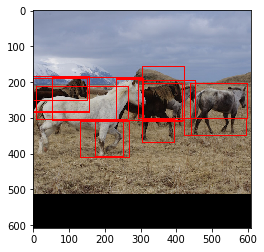

In [245]:
boxes_fliter_merged,result_final_qq_merged = merger_bb_x_axis_final_1(bb_final_filter,result_final_filter_con)
image_copy = reset_image(data_image_dir)
image_copy = draw_box_bb(image_copy,result_final_qq_merged[:,0:4])
plt.imshow(image_copy)

In [246]:
boxes_fliter_merged_y,result_final_qq_merged_q = merger_bb_y_axis_final_1(boxes_fliter_merged,result_final_qq_merged)
image_copy = reset_image(data_image_dir)
#bb_final_filter= np.concatenate((bb_filter_tl,bb_filter_tr,bb_filter_dl,bb_filter_dr),axis=0)
image_copy = draw_box_bb(image_copy,boxes_fliter_merged_y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


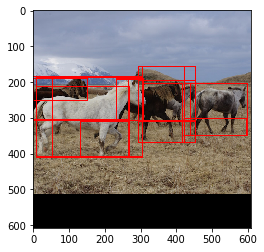

In [247]:
plt.imshow(image_copy)

In [86]:
boxes_fliter_merged_y.shape

(14, 4)

In [87]:
result_final_qq_merged_q.shape

(14, 6)

In [88]:
def filter_boxes_center_y_axis(boxes,result):
    x1 = boxes[:,1:2]
    y1 = boxes[:,0:1]
    y2 = boxes[:,2:3]
    x2 = boxes[:,3:4]
    index = np.argsort(y2,axis=0)
    S_area = (x2-x1)*(y2-y1)
    pick = []
    while(len(index)>0):
        a = index[0]
        pick.append(a)
        suppression =[]
        suppression.append(0)
        for j in range(1,len(index)):
            if np.absolute(y2[index[j]]-y2[a]) <= 50.0:
                x_min = max(x1[index[j]],x1[a])
                y_min = max(y1[index[j]],y1[a])
                x_max = min(x2[index[j]],x2[a])
                y_max = min(y2[index[j]],y2[a])
                intersection_area = np.multiply((x_max - x_min),(y_max- y_min))
                S = float(S_area[index[j]]+S_area[a]-intersection_area)
                iou = np.divide(intersection_area, S)
                if iou >= 0.60:
                    suppression.append(j)
        index = np.delete(index,suppression,axis=0)
    index_q = [i for i in range(len(boxes))]
    suppression = np.delete(index_q,pick,axis=0)
    boxes = np.delete(boxes,suppression,axis =0)
    result = np.delete(result,suppression,axis=0)
    return boxes,result

In [89]:
def filter_boxes_center_x_axis(boxes,result):
    x1 = boxes[:,1:2]
    y1 = boxes[:,0:1]
    y2 = boxes[:,2:3]
    x2 = boxes[:,3:4]
    index = np.argsort(x2,axis=0)
    S_area = (x2-x1)*(y2-y1)
    pick = []
    while(len(index)>0):
        a = index[0]
        pick.append(a)
        suppression =[]
        suppression.append(0)
        for j in range(1,len(index)):
            if (x2[index[j]]-x2[a]) <= 50.0:
                x_min = max(x1[index[j]],x1[a])
                y_min = max(y1[index[j]],y1[a])
                x_max = min(x2[index[j]],x2[a])
                y_max = min(y2[index[j]],y2[a])
                intersection_area = np.multiply((x_max - x_min),(y_max- y_min))
                S = float(S_area[index[j]]+S_area[a]-intersection_area)
                iou = np.divide(intersection_area, S)
                if iou >= 0.60:
                    suppression.append(j)
        index = np.delete(index,suppression,axis=0)
    index_q = [i for i in range(len(boxes))]
    suppression = np.delete(index_q,pick,axis=0)
    boxes = np.delete(boxes,suppression,axis =0)
    result = np.delete(result,suppression,axis=0)
    return boxes,result

In [90]:
bb_center_filter, result_center_filter = filter_boxes_center_y_axis(result_center[:,0:4],result_center)

In [91]:
image_copy_new = reset_image(data_image_dir)
image_center_cp = np.array((608,608,3),dtype = np.float32)
image_center_cp = cv2.resize(image_copy_new[152:429,152:429],(608,608), interpolation = cv2.INTER_LINEAR)
image_center_cp = draw_box_bb(image_center_cp,bb_center_filter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


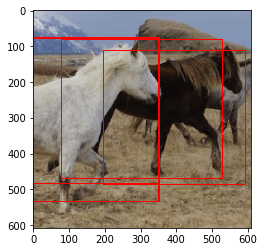

In [92]:
plt.imshow(image_center_cp)

In [93]:
bb_center_filter_x, result_center_filter_x = filter_boxes_center_y_axis(bb_center_filter, result_center_filter)

In [94]:
image_copy_new = reset_image(data_image_dir)
image_center_cp = np.array((608,608,3),dtype = np.float32)
image_center_cp = cv2.resize(image_copy_new[152:429,152:429],(608,608), interpolation = cv2.INTER_LINEAR)
image_center_cp = draw_box_bb(image_center_cp,bb_center_filter_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


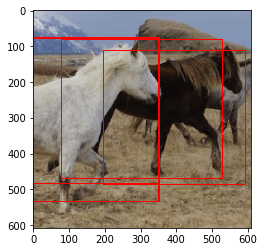

In [95]:
plt.imshow(image_center_cp)

In [96]:
#get back the coordinate of the whole image
scale_final = np.array([[0.5,0.5,0.5,0.5]])
result_center_filter_x[:,0:4] = result_center_filter_x[:,0:4]*scale_final
offset_center = np.array([[152,152,152,152]])
result_center_filter_x[:,0:4] = result_center_filter_x[:,0:4] + offset_center

In [97]:
def second_stage_final_2(result_center_final,result_quarter,threshold = 0.60):
    y1 = result_center_final[:,0:1]
    x1 = result_center_final[:,1:2]
    y2 = result_center_final[:,2:3]
    x2 = result_center_final[:,3:4]
    S_area= np.multiply((y2-y1),(x2-x1))
    index = np.argsort(y2,axis =0)# return the indices that would sort an array
    result_center_final_copy = result_center_final[:,:]
    suppression = []
    P_mg = []
    while(len(result_center_final)> 0):
        last = len(result_center_final)-1
        a = index[last]
        suppression.append(last)
        threshold_max = 0.80
        P_mg.append(a)
        for i in range(0,last):
            x_min = max(x1[index[i]],x1[a])
            y_min = max(y1[index[i]],y1[a])
            x_max = min(x2[index[i]],x2[a])
            y_max = min(y2[index[i]],y2[a])
            intersection_area = np.multiply((x_max - x_min),(y_max- y_min))
            S = float(S_area[index[i]]+S_area[a]-intersection_area)
            iou = np.divide(intersection_area, S)
            if iou > threshold:
                suppression.append(index[i])
            if iou >threshold_max:
                # change the indices of bounding box which has the IoU value larger.
                threshold_max = iou
                a_i = result_center_final[index[i],4:5]
                a_a = result_center_final[a,4:5]
                if a_i <= a_a:
                    P_mg.pop(len(P_mg)-1)
                    P_mg.append(index[i])
        result_center_final = np.delete(result_center_final,suppression,axis=0)
        boxes = boundingbox_final_3(result_quarter,result_center_final_copy,P_mg)
        #P_mg is list of the indices bouding boxes of the center image.
    return boxes  

In [261]:
# merger the bouding box of center image to bounding boxes of all quarter images.
def boundingbox_final_3(bb_quarter,bb_center,index_qq):
    for j in range(len(index_qq)):
        boxes_final = bb_quarter[:,:]
        y1 = bb_center[index_qq[j],0:1]# y1,x1,y2,x2 has the shape (1,)
        x1 = bb_center[index_qq[j],1:2]
        y2 = bb_center[index_qq[j],2:3]
        x2 = bb_center[index_qq[j],3:4]
        # to compute some logic operation
        # need to expand dimension y1,x1,y2,x2 array
        # because yy1,xx1,yy2,xx2 have the shape (1,1)
        y1 = y1[np.newaxis,...]
        x1 = x1[np.newaxis,...]
        y2 = y2[np.newaxis,...]
        x2 = x2[np.newaxis,...]
        yy1 = bb_quarter[:,0:1]
        xx1 = bb_quarter[:,1:2]
        yy2 = bb_quarter[:,2:3]
        xx2 = bb_quarter[:,3:4]
        S_area= np.multiply((yy2-yy1),(xx2-xx1))
        index = np.argsort(xx1,axis=0)
        local_count = 0
        pick = []
        while(len(index)>0):
            last = len(index)-1
            a = index[last]
            suppression=[]
            suppression.append(last)
            if np.absolute(x1-xx1[a]) <= 30.0  or np.absolute(xx2[a]-x2) <= 30.0 :
                if np.cast[np.int32](bb_center[index_qq[j],5:6]) == np.cast[np.int32](bb_quarter[a,5:6]):
                    if bb_quarter[a,4:5] <= 0.6 :
                        x1_new =  np.minimum(xx1[a],x1)
                        y1_new =  np.minimum(yy1[a],y1)
                        x2_new =  np.maximum(xx2[a],x2)
                        y2_new =  np.maximum(yy2[a],y2)
                        if y2_new - y1_new < 100.0:
                            classes = np.cast[np.int32](bb_center[index_qq[j],5:6])
                            scores = np.maximum(bb_center[index_qq[j],4:5],bb_quarter[a,4:5])
                            boxes_new = np.concatenate([y1_new,x1_new,y2_new,x2_new,scores,classes],axis =1)
                            boxes_final = np.concatenate((boxes_final,boxes_new),axis=0)
                            pick.append(a)
            if np.absolute(y1-yy1[a]) <= 30.0 or np.absolute(yy2[a]-y2) <= 30.0:
                if np.cast[np.int32](bb_center[index_qq[j],5:6]) == np.cast[np.int32](bb_quarter[a,5:6]):
                    if bb_quarter[a,4:5] <= 0.6:
                        x1_new =  np.minimum(xx1[a],x1)
                        y1_new =  np.minimum(yy1[a],y1)
                        x2_new =  np.maximum(xx2[a],x2)
                        y2_new =  np.maximum(yy2[a],y2)
                        if y2_new - y1_new < 50.0:
                            classes = np.cast[np.int32](bb_center[index_qq[j],5:6])
                            scores = np.maximum(bb_center[index_qq[j],4:5],bb_quarter[a,4:5])
                            boxes_new = np.concatenate([y1_new,x1_new,y2_new,x2_new,scores,classes],axis =1)
                            boxes_final = np.concatenate((boxes_final,boxes_new),axis=0)
                            pick.append(a)
            index = np.delete(index,suppression,axis=0)
        boxes_final = np.delete(boxes_final,pick,axis=0)
        bb_quarter = boxes_final[:,:]
    return bb_quarter

In [262]:
image_copy = reset_image(data_image_dir)
image_copy = draw_box_bb(image_copy,result_center_filter_x[:,0:4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


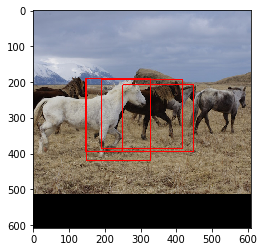

In [263]:
plt.imshow(image_copy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


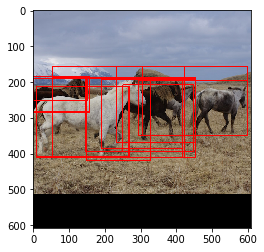

In [101]:
image_copy = draw_box_bb(image_copy,boxes_fliter_merged_y)
plt.imshow(image_copy)

In [264]:
boxes_final_absolute = second_stage_final_2(result_center_filter_x,result_final_qq_merged_q,threshold=0.3)

/home/loan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/loan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [102]:
def draw_result(image,result,labelstext):
    if len(result)==0:
        return image
    else:
        for i in range(len(result)):
            x1 = result[i,1:2]
            y1 = result[i,0:1]
            x2 = result[i,3:4]
            y2 = result[i,2:3]
            cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),2)
            for j,x in enumerate(labelstext):
                if j == np.cast[np.int32](result[i,5:6]):
                    scores = np.cast[np.float16](result[i,4:5])
                    text ="{}:map{:.4f}".format(x,*scores)
                    cv2.putText(image,text,(x1,y1-5.0),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,0),2)
    return image

In [255]:
def filter_after(boxes_filter,result_filter):
    y1 = boxes_filter[:,0:1]
    x1 = boxes_filter[:,1:2]
    y2 = boxes_filter[:,2:3]
    x2 = boxes_filter[:,3:4]
    index = np.argsort(x2,axis=0)
    S_area = np.multiply((y2-y1),(x2-x1))
    pick = []
    while(len(index)>0):
        last = len(index) -1
        a = index[last]
        suppression =[]
        suppression.append(last)
        pick.append(a)
        for i in range(1,len(index)):
            if (x2[index[i]]-x2[a]) <= 50.0 or (x1[index[i]]-x1[a]) <= 50.0:
                x_min = max(x1[index[i]],x1[a])
                y_min = max(y1[index[i]],y1[a])
                x_max = min(x2[index[i]],x2[a])
                y_max = min(y2[index[i]],y2[a])
                intersection_area = np.multiply((x_max - x_min),(y_max- y_min))
                S = float(S_area[index[i]]+S_area[a]-intersection_area)
                iou = np.divide(intersection_area, S)
                if iou > 0.60:
                    suppression.append(i)
            if (y2[index[i]]-y2[a]) <= 50.0 or (y1[index[i]]-y2[a]) <= 50.0:
                x_min = max(x1[index[i]],x1[a])
                y_min = max(y1[index[i]],y1[a])
                x_max = min(x2[index[i]],x2[a])
                y_max = min(y2[index[i]],y2[a])
                intersection_area = np.multiply((x_max - x_min),(y_max- y_min))
                S = float(S_area[index[i]]+S_area[a]-intersection_area)
                iou = np.divide(intersection_area, S)
                if iou > 0.60:
                    suppression.append(i)
        index = np.delete(index,suppression,axis=0)
    index_q = [i for i in range(len(boxes_filter))]
    suppression = np.delete(index_q,pick,axis=0)
    boxes_filter = np.delete(boxes_filter,suppression,axis=0)
    result_filter = np.delete(result_filter,suppression,axis=0)
    return boxes_filter,result_filter

In [265]:
boxes_manually,result_manually = filter_after(boxes_fliter_merged_y2,result_final_qq_merged_q2)

In [266]:
boxes_manually

array([[ 1.85389294e+02, -5.23099433e+00,  3.07099390e+02,
         3.06405803e+02],
       [ 1.88571329e+02,  8.02837444e+00,  4.08621101e+02,
         3.06405803e+02],
       [ 1.56079776e+02,  2.94972470e+02,  3.69993992e+02,
         4.52748268e+02],
       [ 2.04817322e+02,  4.22019954e+02,  3.50621999e+02,
         5.98634499e+02],
       [ 1.91026566e+02, -2.92565472e-01,  2.51766773e+02,
         1.52910668e+02],
       [ 1.92526482e+02,  2.32514269e+02,  3.07144077e+02,
         3.08296779e+02]])

In [267]:
boxes_final_absolute = second_stage_final_2(result_center_filter_x,result_manually,threshold=0.3)

/home/loan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/loan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [268]:
image_copy = reset_image(data_image_dir)
image_copy = draw_result(image_copy,boxes_final_absolute,labelstext)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


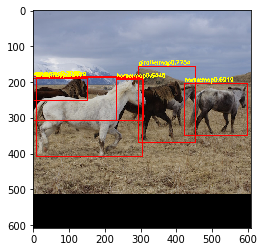

In [269]:
plt.imshow(image_copy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


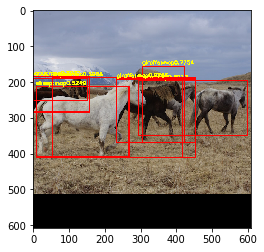

In [151]:
image_copy = reset_image(data_image_dir)
image_copy = draw_result(image_copy,result_final_qq_merged_q,labelstext)
plt.imshow(image_copy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


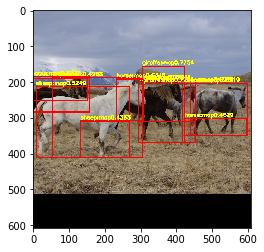

In [214]:
image_copy = reset_image(data_image_dir)
image_copy = draw_result(image_copy,result_final_qq_merged_q,labelstext)
plt.imshow(image_copy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


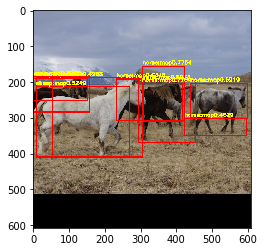

In [237]:
image_copy = reset_image(data_image_dir)
image_copy = draw_result(image_copy,result_final_qq_merged_q2,labelstext)
plt.imshow(image_copy)

In [191]:
result_final_filter_con

array([[ 1.91026566e+02, -2.92565472e-01,  2.51766773e+02,
         1.52910668e+02,  6.21323764e-01,  1.70000000e+01],
       [ 1.85389294e+02, -5.23099433e+00,  2.84211328e+02,
         1.57350005e+02,  8.02486539e-01,  1.70000000e+01],
       [ 1.88571329e+02,  5.44897183e+01,  3.07099390e+02,
         3.06405803e+02,  4.96923625e-01,  1.70000000e+01],
       [ 1.92526482e+02,  2.32514269e+02,  3.07144077e+02,
         3.08296779e+02,  6.44711733e-01,  1.70000000e+01],
       [ 2.13103017e+02,  8.02837444e+00,  3.04311295e+02,
         2.65628859e+02,  5.24681330e-01,  1.80000000e+01],
       [ 1.56079776e+02,  3.05448290e+02,  3.07612338e+02,
         4.21045160e+02,  7.75425076e-01,  1.70000000e+01],
       [ 1.96178233e+02,  2.94972470e+02,  3.02555423e+02,
         4.52748268e+02,  5.08248389e-01,  1.70000000e+01],
       [ 2.04817322e+02,  4.39794206e+02,  3.02967108e+02,
         5.98634499e+02,  6.91698670e-01,  1.70000000e+01],
       [ 2.04025664e+02,  3.04397070e+02,  3.105

In [248]:
boxes_fliter_merged_y2,result_final_qq_merged_q2 = merger_bb_y_axis_final_1(boxes_fliter_merged_y,result_final_qq_merged_q)
image_copy = reset_image(data_image_dir)
#bb_final_filter= np.concatenate((bb_filter_tl,bb_filter_tr,bb_filter_dl,bb_filter_dr),axis=0)
image_copy = draw_box_bb(image_copy,boxes_fliter_merged_y2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


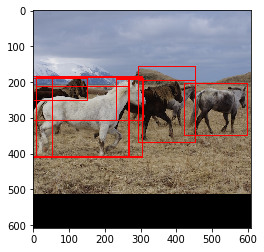

In [249]:
plt.imshow(image_copy)